## Adversarial Membership Inference Attack: Technique Overview
This technique aims to determine whether a specific data point was part of a model's training set (member) or not (non-member).

**How it works:**
1. **Victim Model**: Train a target model (e.g., MLPClassifier) on real data.
2. **Shadow Models**: Train multiple models on random subsets of the data to simulate the victim's behavior for both members and non-members.
3. **Feature Extraction**: For each shadow model, collect features such as output probabilities, per-example loss, and prediction entropy for both member and non-member samples.
4. **Attack Model**: Train a neural network (adversarial model) to distinguish members from non-members using these features.
5. **Inference**: Apply the attack model to the victim model's outputs to predict membership for new samples.

**Why it works:**
Models often behave differently on data they have seen during training (members) versus unseen data (non-members). The adversarial attack exploits these subtle differences in output statistics to infer membership, even without access to the victim model's internals (black-box setting).

### Library Imports Explained
- **numpy, pandas**: For data manipulation and numerical operations.
- **matplotlib.pyplot**: For plotting and visualizations.
- **scikit-learn modules**: For data preprocessing, model training, evaluation, and metrics.
- **MLPClassifier**: Used to train the victim and shadow models for membership inference.
- **tensorflow, keras**: For building and training the adversarial attack neural network.
- **resample**: For creating shadow model training/test splits.

These libraries together enable the workflow for adversarial membership inference attacks: loading and processing data, training models, generating attack features, and evaluating attack effectiveness.

# Adversarial Membership Inference Attack Demo
This notebook demonstrates an adversarial (neural network-based) attack for membership inference.

## 1. Install and Import Required Libraries
Uncomment the pip line if needed.

In [3]:
# Uncomment if needed
# !pip install -U scikit-learn numpy matplotlib pandas tensorflow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, roc_curve



In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

ModuleNotFoundError: No module named 'tensorflow'

## 2. Prepare Synthetic Dataset
We use synthetic text data for demonstration. You can replace this with your own dataset.

In [5]:
# Load and process EduPilot dataset
LABEL_COL = 'interview_round'  # or your actual label column name
df = pd.read_csv('EduPilot_dataset.csv')  # update path if needed
df = df.dropna(subset=[LABEL_COL])
label_words = sorted(df[LABEL_COL].unique())
label_to_id = {w: i for i, w in enumerate(label_words)}
y = df[LABEL_COL].map(label_to_id).astype(int).values
text_cols = ['user_query', 'job_role', 'company', 'location', 'mock_question']
df['text'] = df[text_cols].fillna('').agg(' | '.join, axis=1)
vec = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
X = vec.fit_transform(df['text'])
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y, random_state=42)


## 3. Train Victim Model
Train an MLP classifier as the victim model.

In [5]:
victim = MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=123)
victim.fit(X_train, y_train)

def per_example_loss(model, Xmat, y_true, eps=1e-12):
    proba = model.predict_proba(Xmat)
    rows = np.arange(Xmat.shape[0])
    p_true = np.clip(proba[rows, y_true], eps, 1.0-eps)
    return -np.log(p_true)

train_losses = per_example_loss(victim, X_train, y_train)
test_losses = per_example_loss(victim, X_test, y_test)
print(f"Victim train mean loss: {train_losses.mean():.4f}")
print(f"Victim test mean loss: {test_losses.mean():.4f}")


Victim train mean loss: 0.0086
Victim test mean loss: 0.0997


## 4. Train Shadow Models
Train multiple shadow models to generate data for the adversarial attack.

In [6]:
K_SHADOWS = 30
attack_X = []
attack_y = []

for k in range(K_SHADOWS):
    idx = np.arange(X_train.shape[0])
    tr_idx = resample(idx, n_samples=int(0.6*len(idx)), replace=True, random_state=1000+k)
    te_idx = resample(idx, n_samples=int(0.4*len(idx)), replace=True, random_state=2000+k)
    Xs_tr, ys_tr = X_train[tr_idx], y_train[tr_idx]
    Xs_te, ys_te = X_train[te_idx], y_train[te_idx]

    sh = MLPClassifier(hidden_layer_sizes=(128,), max_iter=200, random_state=42+k)
    sh.fit(Xs_tr, ys_tr)

    # Use output probabilities, loss, and entropy as features
    def entropy(proba):
        return -np.sum(proba * np.log(proba + 1e-12), axis=1)

    # Member examples
    proba_tr = sh.predict_proba(Xs_tr)
    loss_tr = per_example_loss(sh, Xs_tr, ys_tr)
    ent_tr = entropy(proba_tr)
    for i in range(len(loss_tr)):
        attack_X.append(np.concatenate([proba_tr[i], [loss_tr[i], ent_tr[i]]]))
        attack_y.append(1)
    # Non-member examples
    proba_te = sh.predict_proba(Xs_te)
    loss_te = per_example_loss(sh, Xs_te, ys_te)
    ent_te = entropy(proba_te)
    for i in range(len(loss_te)):
        attack_X.append(np.concatenate([proba_te[i], [loss_te[i], ent_te[i]]]))
        attack_y.append(0)

attack_X = np.array(attack_X)
attack_y = np.array(attack_y)
print(f"Attack data shape: {attack_X.shape}")


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

Attack data shape: (2310, 7)


## 5. Train Adversarial Attack Model
Use a neural network to distinguish members from non-members using attack features.

In [7]:
# Split attack data for training/validation
from sklearn.model_selection import train_test_split
attack_X_train, attack_X_val, attack_y_train, attack_y_val = train_test_split(
    attack_X, attack_y, test_size=0.2, stratify=attack_y, random_state=42)

# Build neural network attack model
input_dim = attack_X.shape[1]
attack_model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
attack_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = attack_model.fit(attack_X_train, attack_y_train, epochs=15, batch_size=64,
                           validation_data=(attack_X_val, attack_y_val), verbose=1)


Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4836 - loss: 0.6933 - val_accuracy: 0.7056 - val_loss: 0.6481
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7271 - loss: 0.6309 - val_accuracy: 0.7121 - val_loss: 0.5976
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7374 - loss: 0.5748 - val_accuracy: 0.7359 - val_loss: 0.5613
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7520 - loss: 0.5504 - val_accuracy: 0.7403 - val_loss: 0.5376
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7696 - loss: 0.5159 - val_accuracy: 0.7597 - val_loss: 0.5161
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7809 - loss: 0.4991 - val_accuracy: 0.7792 - val_loss: 0.5019
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7841 - loss: 0.4908 - val_accuracy: 0.7814 - val_loss: 0.4944
Epoch 8/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7911 - loss: 0.4790 - val_accuracy: 0.7814 - val_loss: 0.4903
Ep

## 6. Evaluate Adversarial Attack on Victim Model
Use the trained attack model to infer membership for victim model examples.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Adversarial Attack ROC-AUC: 0.8840


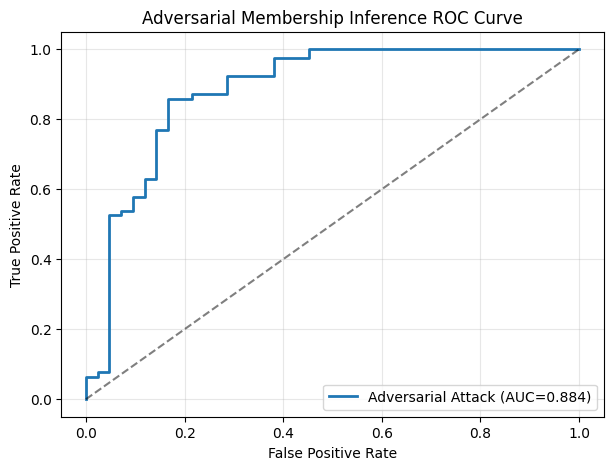

In [8]:
# Prepare victim model features for attack
victim_proba_train = victim.predict_proba(X_train)
victim_loss_train = per_example_loss(victim, X_train, y_train)
victim_ent_train = -np.sum(victim_proba_train * np.log(victim_proba_train + 1e-12), axis=1)

victim_proba_test = victim.predict_proba(X_test)
victim_loss_test = per_example_loss(victim, X_test, y_test)
victim_ent_test = -np.sum(victim_proba_test * np.log(victim_proba_test + 1e-12), axis=1)

victim_attack_X = np.concatenate([
    np.concatenate([victim_proba_train, victim_loss_train[:,None], victim_ent_train[:,None]], axis=1),
    np.concatenate([victim_proba_test, victim_loss_test[:,None], victim_ent_test[:,None]], axis=1)
], axis=0)
victim_attack_y = np.concatenate([np.ones_like(victim_loss_train), np.zeros_like(victim_loss_test)])

# Predict membership
attack_pred = attack_model.predict(victim_attack_X).flatten()
auc = roc_auc_score(victim_attack_y, attack_pred)
fpr, tpr, _ = roc_curve(victim_attack_y, attack_pred)

print(f"Adversarial Attack ROC-AUC: {auc:.4f}")
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'Adversarial Attack (AUC={auc:.3f})', lw=2)
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Adversarial Membership Inference ROC Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
